## Contexto

Suponhamos que temos um conjunto de dados de uma empresa de e-commerce com registros de compras com os seguintes atributos: descrição do produto, quantidade comprada, data da compra, o valor unitário do produto, o id do cliente e o país do cliente. O chefe dessa empresa gostaria de conhecer os seus clientes para criar estratégias e campanhas de fidelização.  

**Uma das formas simples para isso é utilizando o RFM.** 

-> O RFM análise a Recência, Frequência de compra e a Monetaridade de cada cliente, possibilitando mapear e classificar os clientes.

    -> Recência: é há quantos dias foi a última compra do cliente.
    -> Frequência: quantidade de compra que o cliente fez na sua empresa. 
    -> Monetaridade: é o quanto o cliente gasto na empresa. 

**Forma de calcular:**

    1. Ordene os clientes por Recência (menor para o maior)
    2. Divide a base de clientes em 5 partes iguais, dando notas de 1 a 5.
    3. Ordene por Frequência. (maior para o menor)
    4. Divide a base de clientes em 5 partes iguais, dando notas de 1 a 5.
    5. Ordene por Monetaridade.(maior para o menor)
    6. Divide a base de clientes em 5 partes iguais, dando notas de 1 a 5.
    
Exemplo: Recência menor pontuação maior, Frequencia de compra maior nota maior e Monetariade maior nota alta. 

Fique assim:

cliente | R | F | M
-------| ------- | ----- | -----
01 | 1 | 2 | 4
05 | 2 | 5 | 5
08 | 5 | 5 | 5

    7. Calcule (média ou mediana) das Notas R, F e M (RFM score)
    
**Através do RFM score, podemos ordenar uma lista de clientes, descobrindo quais são os melhores clientes por base da sua recência, frequência e monetaridade.**

## Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

## Dados - análise

In [2]:
df_raw = pd.read_csv('data/data.csv', encoding='ISO-8859-1')

In [3]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
print(f'Quantidade de linhas:{df_raw.shape[0]}')
print(f'Quantidade de colunas:{df_raw.shape[1]}')

Quantidade de linhas:541909
Quantidade de colunas:8


In [5]:
# descobrindo a quantidade de NAs
df_raw.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# nesse primeiro momento irei excluir os na
df1 = df_raw.dropna()

In [7]:
df1.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
print(f'Quantidade de registros depois de excluir os NAs: {df1.shape[0]}')

Quantidade de registros depois de excluir os NAs: 406829


In [9]:
# porcentagem dos dados que são na
a = (df_raw.shape[0] - df1.shape[0]) / df_raw.shape[0]
print(f'A porcentagem dos dados que são NA: {round(a*100,1)}%')

A porcentagem dos dados que são NA: 24.9%


In [10]:
# duplicates
print(f'Total de linhas duplicadas: {df1[df1.duplicated].shape[0]}')

Total de linhas duplicadas: 5225


In [11]:
# excluindo as linhas duplicadas
df1 = df1.drop_duplicates()

In [12]:
print(f'Tamanho do conjunto de dados sem NAs e sem duplicadas: {df1.shape[0]}')

Tamanho do conjunto de dados sem NAs e sem duplicadas: 401604


In [13]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [14]:
df1['CustomerID'] = df1['CustomerID'].astype(int)

## Criando features de Recencia | Frequencia | Monetaridade

In [15]:
# montando um dataframe como:
# customer_id | recency | frequency | monetary value

# data referencia
df_ref = df1.drop(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'Country'], axis=1).drop_duplicates(ignore_index=True)

In [16]:
# monetary value = quantity * unitprice
df1['Monetary'] = df1['Quantity'] * df1['UnitPrice']

aux1 = df1[['CustomerID','Monetary']].groupby('CustomerID').sum().reset_index()

# merge 

df_ref = pd.merge(df_ref, aux1, on='CustomerID', how='left')

In [17]:
# frequency
aux2 = df1[['CustomerID', 'InvoiceNo']].groupby('CustomerID').count().reset_index()

# merge
df_ref = pd.merge(df_ref, aux2, on='CustomerID', how='left')

df_ref = df_ref.rename(columns={'InvoiceNo': 'Frequency'})

In [18]:
# recency
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'], format='%m/%d/%Y %H:%M')

aux3 = df1[['CustomerID', 'InvoiceDate']].groupby('CustomerID').max().reset_index()

aux3['Recency'] = (df1['InvoiceDate'].max() - aux3['InvoiceDate']).dt.days

aux3 = aux3[['CustomerID', 'Recency']].copy()

# merge
df_ref = pd.merge(df_ref, aux3, on='CustomerID', how='left')

In [19]:
df_ref.head()

,CustomerID,Monetary,Frequency,Recency
0,17850,5303.48,309,301
1,13047,3079.10,196,31
2,12583,7187.34,251,2
3,13748,948.25,28,95
4,15100,635.10,6,329


## Análise RFM

In [20]:
df_rfm = df_ref.copy()

In [21]:
# Monetary
# labels
niveis_m = range(1,6)

# quintis
df_rfm['M'] = pd.qcut(df_rfm['Monetary'], q=5, labels=niveis_m)

df_rfm['M'] = df_rfm['M'].astype(int)

In [22]:
# Frequency
# labels
niveis_m = range(1,6)

# quintis
df_rfm['F'] = pd.qcut(df_rfm['Frequency'], q=5, labels=niveis_m)

df_rfm['F'] = df_rfm['F'].astype(int)

In [23]:
# Recency
# labels
niveis_m = range(5,0,-1)

# quintis
df_rfm['R'] = pd.qcut(df_rfm['Recency'], q=5, labels=niveis_m)

df_rfm['R'] = df_rfm['R'].astype(int)

In [24]:
df_rfm

,CustomerID,Monetary,Frequency,Recency,M,F,R
0,17850,5303.48,309,301,5,5,1
1,13047,3079.10,196,31,5,5,4
2,12583,7187.34,251,2,5,5,5
3,13748,948.25,28,95,4,2,2
4,15100,635.10,6,329,3,1,1
...,...,...,...,...,...,...,...
4367,13436,196.89,12,1,1,1,5
4368,15520,343.50,18,1,2,2,5
4369,13298,360.00,2,0,2,1,5
4370,14569,227.39,12,0,1,1,5


### RFM - Score

In [25]:
df_rfm['RFMscore'] = round( ( (df_rfm[ ['F','M', 'R'] ].sum(axis=1) ) / 3 ), 1 )
df_rfm.sort_values(by='RFMscore', ascending=False).head()

,CustomerID,Monetary,Frequency,Recency,M,F,R,RFMscore
752,14298,50862.44,1640,2,5,5,5,5.0
1314,14701,2462.94,342,10,5,5,5,5.0
3134,12627,4478.53,230,10,5,5,5,5.0
2225,14546,2482.86,415,3,5,5,5,5.0
3119,14456,3002.51,954,4,5,5,5,5.0


  É através do **RFM score** que podemos listar os melhor clientes da empresa em primeiro da lista. 

## RFM - Segmentation

<img src="https://cdn3.notifyvisitors.com/blog/wp-content/uploads/2021/08/Customer-Segmentation-Using-RFM-Analysis.jpg">

Calculando a média dos valores de frequencia e monetaridade para posterior montar uma matriz como refência para desmentar os clientes.

In [26]:
#Média de F+M
df_rfm['FM_mean'] = round( ( (df_rfm[ ['F','M'] ].sum(axis=1) ) / 2 ), 0 )

In [27]:
df_rfm['FM_mean'] = df_rfm['FM_mean'].astype('int64')

In [28]:
df_rfm.sort_values(by='FM_mean', ascending=False).head()

,CustomerID,Monetary,Frequency,Recency,M,F,R,RFMscore,FM_mean
0,17850,5303.48,309,301,5,5,1,3.7,5
745,14057,6141.10,290,23,5,5,4,4.7,5
748,18044,2085.65,128,3,5,5,5,5.0,5
750,16191,4913.32,151,2,5,5,5,5.0,5
751,12370,3541.94,166,50,5,5,3,4.3,5


In [29]:
rfm_pivot = df_rfm.pivot_table(values='CustomerID', index='FM_mean', columns='R', aggfunc='count')

rfm_pivot = rfm_pivot.loc[[5,4,3,2,1],[1,2,3,4,5]]

In [30]:
rfm_pivot

R,1,2,3,4,5
FM_mean,,,,,
5,8,33,88,169,319
4,77,233,273,349,325
3,74,156,129,122,82
2,432,317,275,198,114
1,284,121,92,66,36


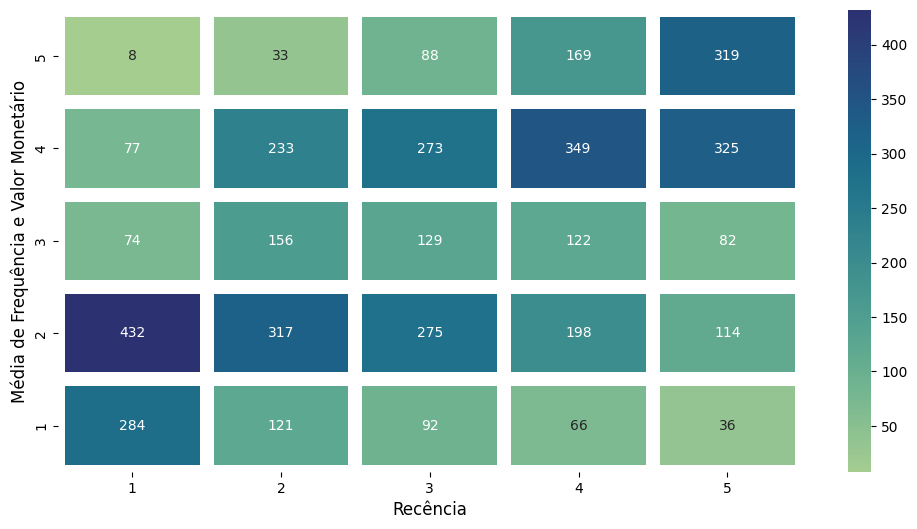

In [31]:
#Visualizando em um mapa de calor

plt.figure(figsize=(12,6))

# heatmap
plot = sns.heatmap(rfm_pivot, annot=True, fmt='d', linewidths=10, 
            cmap='crest', annot_kws={"fontsize":10})

plot.set_xlabel('Recência', fontsize=12)
plot.set_ylabel('Média de Frequência e Valor Monetário', fontsize=12)

plt.show();

Através do heatmap é possível visualizar a distribuição dos clientes de acordo com a Recência e a média de frequencia e monetaridade.

#### Classificando os clientes

<img src="https://pocket-image-cache.com//filters:format(jpg):extract_focal()/https%3A%2F%2Fmiro.medium.com%2Fmax%2F1600%2F1*bGkBVQ_V5_JadgNiyAgiiw.png">

In [32]:
def classificar(df):
    if (4 <= df['FM_mean'] <= 5) and (4 <= df['R'] <= 5):
        return 'Champions'
    elif (3 <= df['FM_mean'] <= 5) and (2 <= df['R'] <= 5):
        return 'Loyal Customers'
    elif (1 <= df['FM_mean'] <= 3) and (3 <= df['R'] <= 5):
        return 'Potential Loyalist'
    elif (0 <= df['FM_mean'] <= 1) and (3 <= df['R'] <= 4):
        return 'New Customers'    
    elif (0 <= df['FM_mean'] <= 1) and (3 <= df['R'] <= 4):
        return 'Promising'    
    elif (2 <= df['FM_mean'] <= 3) and (2 <= df['R'] <= 3):
        return 'Customers Needing Attention' 
    elif (0 <= df['FM_mean'] <= 2) and (2 <= df['R'] <= 3):
        return 'About to Sleep'     
    elif (2 <= df['FM_mean'] <= 5) and (0 <= df['R'] <= 2):
        return 'At Risk'     
    elif (4 <= df['FM_mean'] <= 5) and (0 <= df['R'] <= 1):
        return 'Can´t Lose Them'
    elif (1 <= df['FM_mean'] <= 2) and (1 <= df['R'] <= 2):
        return 'Hibernating'
    elif (0 <= df['FM_mean'] <= 2) and (0 <= df['R'] <= 2):
        return 'Lost'       


<img src="https://pocket-image-cache.com//filters:format(jpg):extract_focal()/https%3A%2F%2Fmiro.medium.com%2Fmax%2F1600%2F1*JXuxk7w8CCd5aKref26EmA.png">

In [33]:
df_rfm['Classe'] = df_rfm.apply(classificar,axis=1)
df_rfm

,CustomerID,Monetary,Frequency,Recency,M,F,R,RFMscore,FM_mean,Classe
0,17850,5303.48,309,301,5,5,1,3.7,5,At Risk
1,13047,3079.10,196,31,5,5,4,4.7,5,Champions
2,12583,7187.34,251,2,5,5,5,5.0,5,Champions
3,13748,948.25,28,95,4,2,2,2.7,3,Loyal Customers
4,15100,635.10,6,329,3,1,1,1.7,2,At Risk
...,...,...,...,...,...,...,...,...,...,...
4367,13436,196.89,12,1,1,1,5,2.3,1,Potential Loyalist
4368,15520,343.50,18,1,2,2,5,3.0,2,Potential Loyalist
4369,13298,360.00,2,0,2,1,5,2.7,2,Potential Loyalist
4370,14569,227.39,12,0,1,1,5,2.3,1,Potential Loyalist


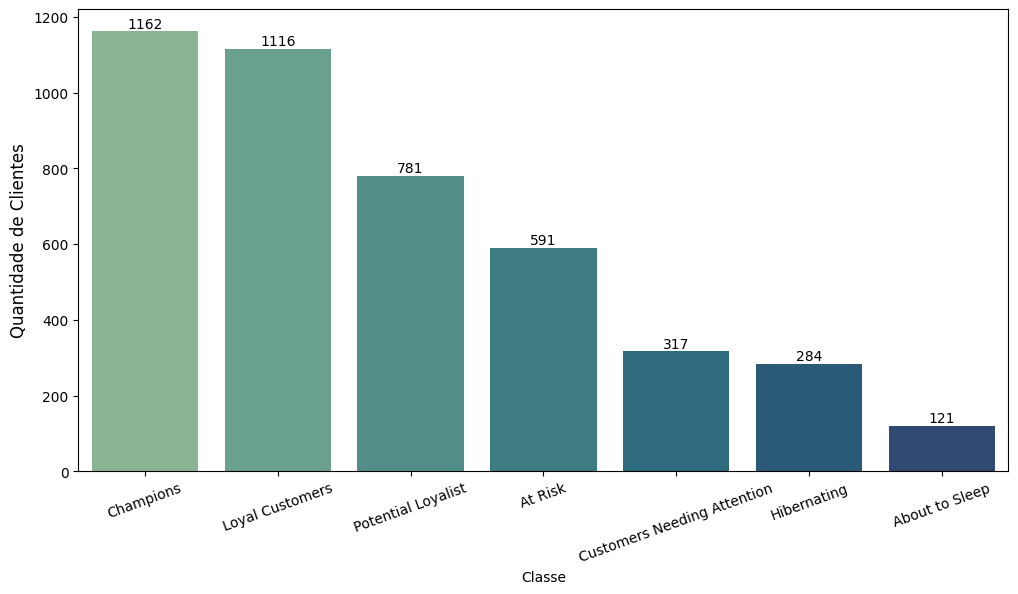

In [34]:
df_plot = df_rfm[['CustomerID', 'Classe']].groupby('Classe').count().reset_index().sort_values(by='CustomerID',
                                                                                              ascending=False)

plt.figure(figsize=(12,6))


plot = sns.barplot(x='Classe', y='CustomerID', data=df_plot, palette='crest')
plot.bar_label(plot.containers[0])

plot.set_ylabel('Quantidade de Clientes', fontsize=12)
plt.xticks(rotation=20)
plt.show();

In [35]:
df_rfm.loc[df_rfm['R'] == 'Lost',:]

,CustomerID,Monetary,Frequency,Recency,M,F,R,RFMscore,FM_mean,Classe


Através dessa classificação dos meus clintes é possivel responder as seguintes perguntas:

    -> Quam são os melhores clientes?
    -> Quais clientes são próximos de churn?
    -> Quais os potenciais clientes para entrar no programa de Fidelização?
    -> Quais clientes são mais provaveis de responder as campanhas de marketing?